In [1]:
import numpy as np
from pathlib import Path
from typing import Tuple
from typing import Union
from typing import Optional

STAT_ROOT = Path('../stat_exp_checkpoint')

In [2]:
import seaborn
seaborn.set_theme()

import matplotlib.pyplot as plt
from contextlib import contextmanager

@contextmanager
def switch_plt_backend(backend="agg"):
    # Put here what would ordinarily go in the `__enter__` method
    # In this case, there's nothing to do
    backend = plt.get_backend()
    plt.switch_backend("agg")
    try:
        yield # You can return something if you want, that gets picked up in the 'as'
    except Exception:
        pass
    finally:
        plt.switch_backend(backend)

In [3]:
def stability_score(diag_probs):
    """ Assessment of the stability of the prediction of the model at different image shifts 
    diag_probs:    model prediction confidence at different image shifts 
    """
    return np.var(diag_probs[..., 1:] - diag_probs[..., :-1], axis=2)


def get_stat_diag_probs(folder_path: Union[str, Path]):
    return np.stack([
        np.load(m_folder / 'diag_probs.npy')
        for m_folder in sorted(folder_path.iterdir())
        if m_folder.is_dir()
    ]).transpose((1, 0, 2))


def stat_probs_from_folder(folder_path: str, index=None) -> Tuple[np.ndarray]:
    
    folder_path = Path(folder_path)
    confid_diag_probas = get_stat_diag_probs(folder_path)

    if index is None:
        confid_diag_probas = confid_diag_probas.mean(axis=0)
        mean, std = confid_diag_probas.mean(axis=0), confid_diag_probas.std(axis=0)
    elif index=="all":
        mean, std = [], []
        for confid_diag_prob in confid_diag_probas:
            mean_, std_ = confid_diag_prob.mean(axis=0), confid_diag_prob.std(axis=0)
            mean.append(mean_)
            std.append(std_)
        mean, std = np.array(mean), np.array(std)    
    else:    
        confid_diag_probas = confid_diag_probas[index]
        mean, std = confid_diag_probas.mean(axis=0), confid_diag_probas.std(axis=0)

    return mean, std


def plot_exp_consist(folder_path: str, ax: plt.Axes, show_std: bool = False, label=None, index=None):

    if index=="all":
        raise NotImplementedError('Value index "all" is not supported')
    
    folder_path = Path(folder_path)
    mean, std = stat_probs_from_folder(folder_path, index=index)
    x = np.arange(1, len(mean) + 1)
    
    if not label:
        label = folder_path.name
    
    ax.plot(x, mean, label=label)

    if show_std:
        ax.fill_between(x, mean - std, mean + std, alpha=0.2)

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.17), prop={'size': 13})

In [4]:
import sys
sys.path.append("..")
from datasets.cifar100 import get_cifar100_test_dataloader, unnormalize_batch
from torchvision.transforms.functional import resize

def get_gridspec(figure, grid_label):

    if not figure._gridspecs:
        raise ValueError("gridspec's list is empty")

    for gridspec in figure._gridspecs:
        if gridspec.figure.get_label() == grid_label:
            return gridspec
    
    raise ValueError("gridspec not found")


def add_gridspec(figure, nrows: int = 1, ncols: int = 1, grid_label: str = "",  **kwargs):

    gridspec = figure.add_gridspec(nrows, ncols, **kwargs)

    if grid_label == "":
        grid_label = str(len(figure._gridspecs))

    gridspec.figure.set_label(grid_label)

    return gridspec

def tensor_to_numpy(img):
    img = unnormalize_batch(img)
    img = img[0].numpy()
    return img.transpose((1, 2, 0))


def imshow(img, ax=None):
    if ax is None:
        ax = plt
    img = tensor_to_numpy(img)
    ax.imshow(img)
    ax.axis('off')
    del ax


def save_imgs_shift(imgs, labels, folder, D: int = 8):

    folder = Path(folder)
    folder.mkdir(parents=True, exist_ok=True)
    with switch_plt_backend('agg'):
        orig_size = imgs[0].shape[-1] - D
        for i, image in enumerate(imgs):
            for off in range(D):
                img = image[..., off:off + orig_size, off:off + orig_size]
                imshow(img)
                plt.savefig(str(folder/ f"img{labels[i]}_off{off}"), pad_inches=0.0, bbox_inches='tight')
    

def draw_imgs_shift(imgs, gridspec, D: int = 8):

    with switch_plt_backend('agg'):
        orig_size = imgs[0].shape[-1] - D
        for i, image in enumerate(imgs):
            for off in range(D):
                ax = gridspec.figure.add_subplot(gridspec[i, off])
                img = image[..., off:off + orig_size, off:off + orig_size]
                imshow(img, ax=ax)
    

def violinplot_confidence(confids, violin_gridspec, violin_column_ind: Optional[int] = None, title='', fontsize=20, min_xticks=None, vert=False, widths=0.4):
    
    if len(confids) == 0:
        return
    
    if violin_column_ind is None:
        violin_column_ind = 0  

    with switch_plt_backend('agg'):
        for violin_row_ind, img_conf in enumerate(confids):
            ax = violin_gridspec.figure.add_subplot(violin_gridspec[violin_row_ind, violin_column_ind])
            if violin_row_ind == 0:
                ax.set_title(title, fontsize=fontsize + 4)

            ax.violinplot(
                img_conf, 
                vert=vert,
                widths=widths,
            )
            
            ax.tick_params(labelsize=fontsize)                 
            
            if min_xticks is None:
                left = img_conf.min()
            else:
                left = min_xticks[violin_row_ind]
                
            ax.set_xlim(left=left*0.95, right=img_conf.max()*1.05)

            yticks = ax.get_yticks()
            
            m_y = yticks.min()
            r_y = (yticks.max() - m_y)/4. 
 
            ax.vlines(img_conf, r_y + m_y, 3*r_y + m_y, colors="b", linestyles ="dashed")
            ax.set_yticks([])
            plt.show()
            del ax


In [5]:
exp_name1 = Path(STAT_ROOT) / 'resnet18'
#exp_name2 = Path(STAT_ROOT) / 'resnet18_bss2_rc_aug_1.0_aug_mode_pad_log_no_w'
exp_name3 = Path(STAT_ROOT) / 'resnet18_lpf3_bss1_rc_aug_1.0_aug_mode_pad_log_no_w'
exp_name4 = Path(STAT_ROOT) / 'resnet18_bss2_rc_aug_0.9_aug_mode_pad_log_cross_loss_3.0w_start80_temp15_log_no_w'

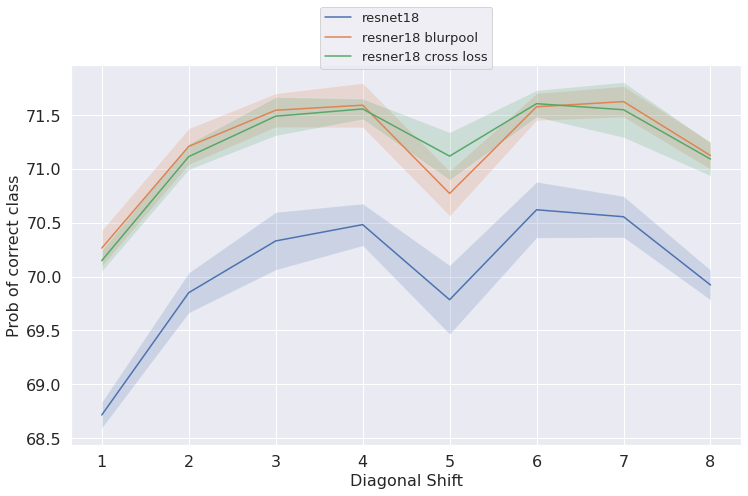

In [6]:
figsize = (12, 7)

fig, ax = plt.subplots(figsize=figsize)

ax.tick_params(labelsize=16)
ax.set_ylabel('Prob of correct class', fontsize=16)
ax.set_xlabel('Diagonal Shift', fontsize=16)

show_std = True

index = None
plot_exp_consist(exp_name1, ax, show_std=show_std, index=index)
plot_exp_consist(exp_name3, ax, show_std=show_std, label="resner18 blurpool", index=index)
plot_exp_consist(exp_name4, ax, show_std=show_std, label="resner18 cross loss", index=index)

fig.savefig('./full_figure.png', pad_inches=0.2, bbox_inches='tight')


In [7]:
mean, std = stat_probs_from_folder(exp_name1, index="all")
mean_bp, std_bp = stat_probs_from_folder(exp_name3, index="all")
mean_cl, std_cl = stat_probs_from_folder(exp_name4, index="all")

img_indexes = sorted(
    range(len(mean)), 
    key=lambda ind: mean[ind].mean() + mean_bp[ind].mean() + mean_cl[ind].mean() + 2*( std[ind].max() + (std[ind].max() - std[ind].min()) - (std_bp[ind].max() - std_bp[ind].min())), 
    reverse=True)

In [8]:
D = 8

val_dataset = get_cifar100_test_dataloader(
    data_root="..",
    num_workers=1,
    batch_size=1,
    shuffle=False,
    img_pad=4
).dataset

imgs = []
labels = []
for i in range(5):
    img, lab = val_dataset[img_indexes[i]]
    imgs.append(img)
    labels.append(lab)

Files already downloaded and verified


In [9]:
size = (fig.get_size_inches()*fig.dpi).astype(int)

In [10]:
size.astype(int)

array([864, 504])

In [11]:
ax.get_yticks()

array([68. , 68.5, 69. , 69.5, 70. , 70.5, 71. , 71.5, 72. ])

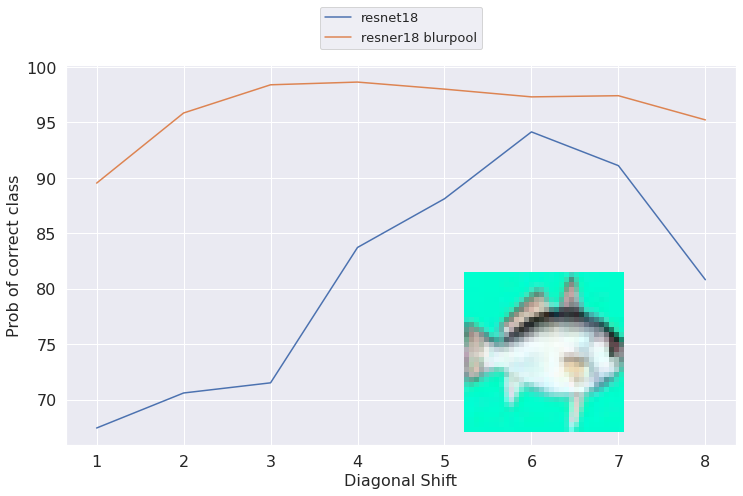

In [12]:
from PIL.Image import NONE

figsize = (12, 7)

fig, ax = plt.subplots(figsize=figsize)

ax.tick_params(labelsize=16)
ax.set_ylabel('Prob of correct class', fontsize=16)
ax.set_xlabel('Diagonal Shift', fontsize=16)

show_std = False

index = img_indexes[0]
plot_exp_consist(exp_name1, ax, show_std=show_std, index=index)
plot_exp_consist(exp_name3, ax, show_std=show_std, label="resner18 blurpool", index=index)
# plot_exp_consist(exp_name4, ax, show_std=show_std, label="resner18 cross loss", index=index)


img = imgs[0]
right, left = img.shape[-1] - D//2, D//2
img = img[..., left:right, left:right]
new_size = img.shape[-1]*5
img = resize(img, (new_size, new_size), interpolation=NONE)

fig.figimage(tensor_to_numpy(img), figsize[1]*fig.dpi - new_size//4, new_size//2.5)

fig.savefig('./full_figure.png', pad_inches=0.2, bbox_inches='tight')


In [13]:
# save_imgs_shift(imgs, labels, "shifts", D)

In [14]:
fig = plt.figure(figsize=(40, 20), constrained_layout=False)

imgs_gridspec = fig.add_gridspec(len(imgs), D, left=0.0, right=0.5, wspace=0.0, hspace=0.3)
draw_imgs_shift(imgs, imgs_gridspec, D=D)

In [ ]:
violin_gridspec = fig.add_gridspec(5, 3, left=0.51, right=0.99, hspace=0.3)

In [ ]:
violinplot_confidence(
    mean[img_indexes[:5]],
    violin_gridspec, 0,
    title='original',
)    

min_xticks = [img_conf.min() for img_conf in mean[img_indexes[:5]]]

# violinplot_confidence(
#     mean_bp[img_indexes[:5]],
#     violin_gridspec, 1,
#     title='blurpool', min_xticks=min_xticks
# )    

# violinplot_confidence(
#     mean_cl[img_indexes[:5]],
#     violin_gridspec, 2,
#     title='our', min_xticks=min_xticks
# )

In [ ]:
fig.savefig("output-bp.png", pad_inches=0.2, bbox_inches='tight')
plt.close(fig)